In [1]:
library("broom")
library("dplyr")
library("ggplot2")
library("STRbook")
library("purrr")
library("tidyr")


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [2]:
data("SST_df", package = "STRbook")

In [3]:
data("SSTlandmask", package = "STRbook")
data("SSTdata", package = "STRbook")
data("SSTlonlat", package = "STRbook")

In [4]:
lonlatmask_df <- data.frame(cbind(SSTlonlat, SSTlandmask))
names(lonlatmask_df) <- c("lon", "lat", "mask")

In [5]:
SSTdata <- cbind(lonlatmask_df, SSTdata)

In [7]:
SST_df <- gather(SSTdata, date, sst, -lon, -lat, -mask)
SST_df %>% head(3)

,lon,lat,mask,date,sst
,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,124,-29,1,V1,-0.3628883
2,126,-29,1,V1,-0.2846108
3,128,-29,1,V1,-0.1919537


In [8]:
date_grid <- expand.grid(Month = c("Jan", "Feb", "Mar", "Apr",
"May", "Jun", "Jul", "Aug",
"Sep", "Oct", "Nov", "Dec"),
Year = 1970:2002,
stringsAsFactors =
FALSE)
date_grid$date <- paste0("V", 1:396)
SST_df <- left_join(SST_df, date_grid) %>%
select(-date)

Joining with `by = join_by(date)`


In [9]:
SST_df$date <- paste(SST_df$Month, SST_df$Year)
SST_df %>% head(3)

,lon,lat,mask,sst,Month,Year,date
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>
1,124,-29,1,-0.3628883,Jan,1970,Jan 1970
2,126,-29,1,-0.2846108,Jan,1970,Jan 1970
3,128,-29,1,-0.1919537,Jan,1970,Jan 1970


In [10]:
SST_df$sst<- ifelse(SST_df$mask == 0, SST_df$sst, NA)

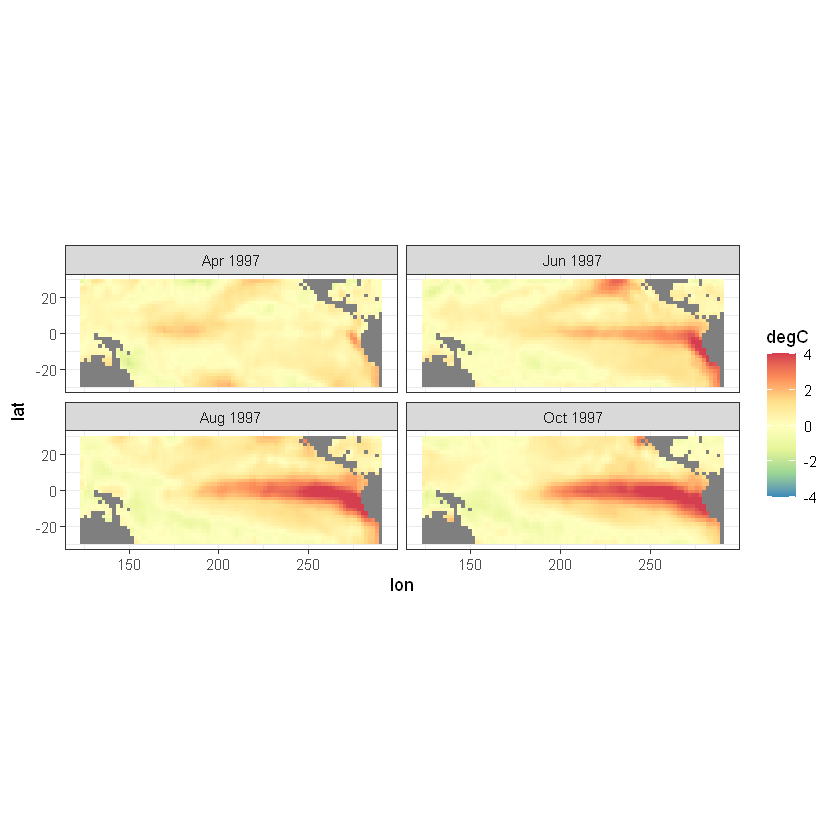

In [12]:
g <- ggplot(filter(SST_df, Year == 1997 &
# subset by month/year
Month %in% c("Apr","Aug","Jun","Oct"))) +
geom_tile(aes(lon, lat,
fill = pmin(sst, 4))) +
# clamp SST at 4deg
facet_wrap(~date, dir = "v") +
# facet by date
fill_scale(limits = c(-4, 4),
# color limits
name = "degC") +
# legend title
theme_bw() + coord_fixed()

g

In [13]:
data("SOI", package = "STRbook")
SOI_df <- select(SOI, -Ann) %>%
gather(Month, soi, -Year)

In [14]:
SST_df <- left_join(SST_df, SOI_df,
by = c("Month", "Year"))

In [15]:
SST_pre_May <- filter(SST_df, Year <= 1997) %>%
filter(!(Year == 1997 &
Month %in% c("May", "Jun", "Jul",
"Aug", "Sep", "Oct",
"Nov", "Dec")))

In [18]:
fit_one_pixel <- function(data)
mod <- lm(sst ~ 1 + soi, data = data)
pixel_lms <- SST_pre_May %>%
filter(!is.na(sst)) %>%
group_by(lon, lat) %>%
nest() %>%
mutate(model = map(data, fit_one_pixel)) %>%
mutate(model_df = map(model, tidy))



In [22]:
# pixel_lms
lm_pars <- pixel_lms %>%
unnest(model_df)

In [25]:
# head(lm_pars, 3)
lm_pars <- left_join(lonlatmask_df, lm_pars)

Joining with `by = join_by(lon, lat)`


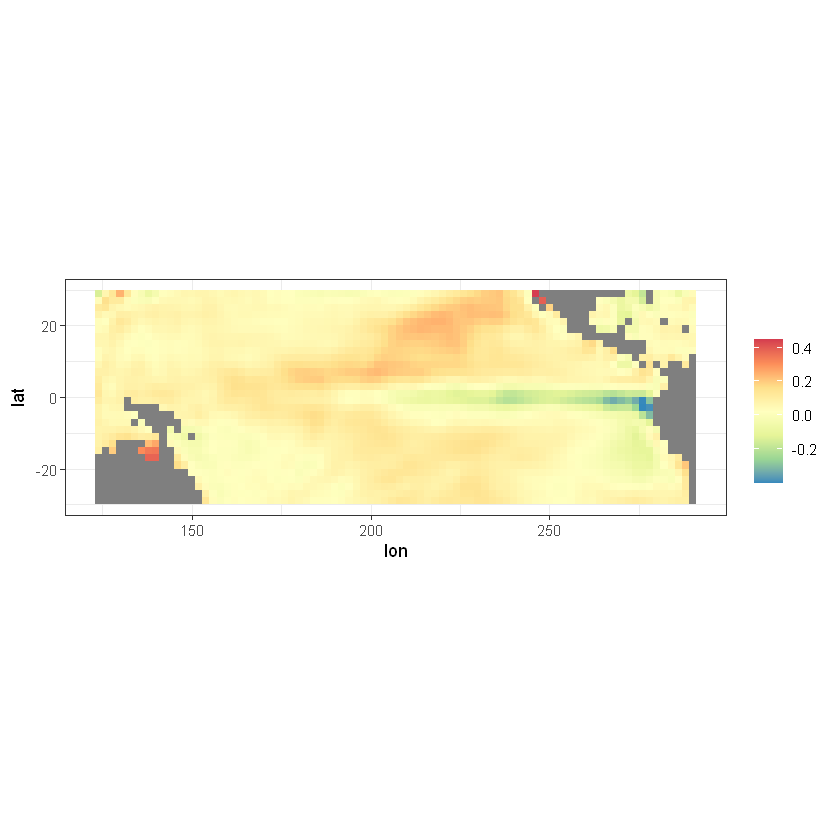

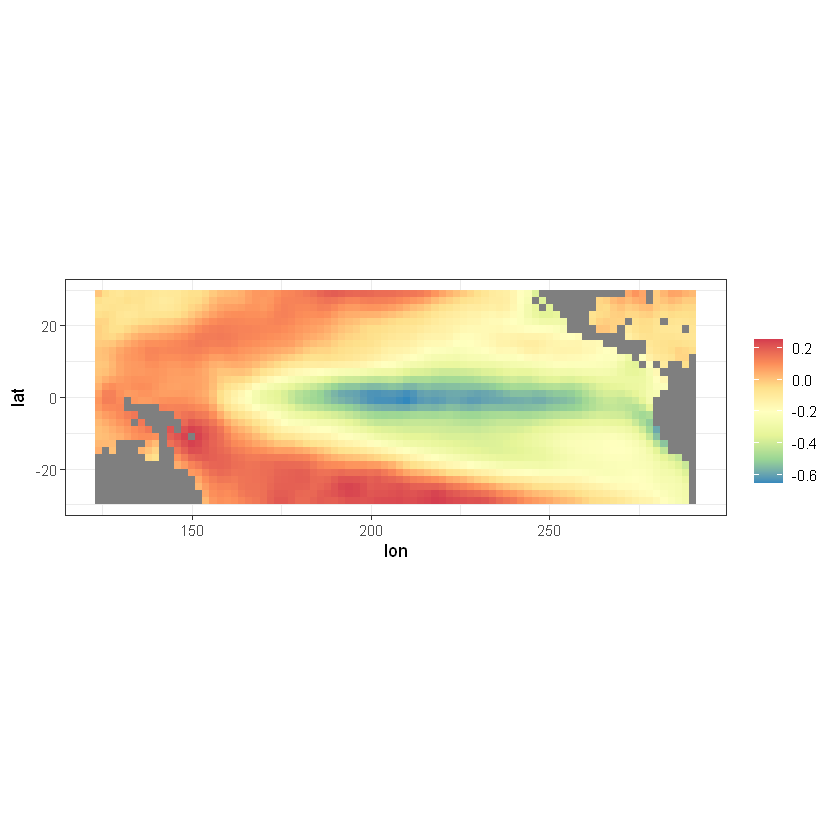

In [26]:
g2 <- ggplot(filter(lm_pars, term == "(Intercept)" | mask == 1)) +
geom_tile(aes(lon, lat, fill = estimate)) +
fill_scale() +
theme_bw() + coord_fixed()
g3 <- ggplot(filter(lm_pars, term == "soi" | mask == 1)) +
geom_tile(aes(lon, lat, fill = estimate)) +
fill_scale() +
theme_bw() + coord_fixed()

g2

g3

In [28]:
soi_pred <- filter(SOI_df, Month == "Oct" & Year == "1997") %>%
select(soi)

In [29]:
predict_one_pixel <- function(lm, soi_pred) {
predict(lm,
# linear model
newdata = soi_pred,
# pred. covariates
interval = "prediction") %>%
# output intervals
data.frame() %>%
# convert to df
mutate(se = (upr-lwr)/(2 * 1.96)) %>% # comp pred. se
select(fit, se)
# return fit & se
}

In [30]:
SST_Oct_1997 <- pixel_lms %>%
mutate(preds = map(model,
predict_one_pixel,
soi_pred = soi_pred)) %>%
unnest(preds)